#Upload dataset from kaggle.com

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download flo2607/traffic-signs-classification

 92% 60.0M/65.5M [00:00<00:00, 60.7MB/s]
100% 65.5M/65.5M [00:00<00:00, 82.8MB/s]


In [8]:
! unzip myData.zip

  inflating: myData/9/33_26840_1577672014.3899367.jpg  
  inflating: myData/9/33_26841_1577672014.3899367.jpg  
  inflating: myData/9/33_26842_1577672014.3909323.jpg  
  inflating: myData/9/33_26843_1577672014.3919306.jpg  
  inflating: myData/9/33_26844_1577672014.392931.jpg  
  inflating: myData/9/33_26845_1577672014.3939247.jpg  
  inflating: myData/9/33_26846_1577672014.3949218.jpg  
  inflating: myData/9/33_26847_1577672014.395919.jpg  
  inflating: myData/9/33_26848_1577672014.395919.jpg  
  etc...


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

#Import necessery libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizer_v2 import adam as adam_v2
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator
 
 
#Define parameters
 
path = "myData" # path of the folder contains all the images directories
labelFile = 'newLabels.csv'
batch_size_val=50  # how many to process together
steps_per_epoch_val=2000
epochs_val=10
imageDimesions = (32,32,3)
testRatio = 0.2    # divide 20% of the dataset to test
validationRatio = 0.2 # divide the left 80% to another 20% which goes for validation

#Display information about the dataset

Total Classes Detected: 13
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12  
Data Shapes
Train(18565, 32, 32, 3) (18565,)
Validation(4642, 32, 32, 3) (4642,)
Test(5802, 32, 32, 3) (5802,)
data shape  (13, 2) <class 'pandas.core.frame.DataFrame'>
[931, 290, 3188, 1667, 2212, 1787, 2636, 1314, 290, 844, 509, 1433, 1464]


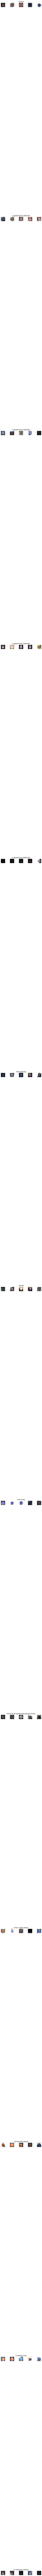

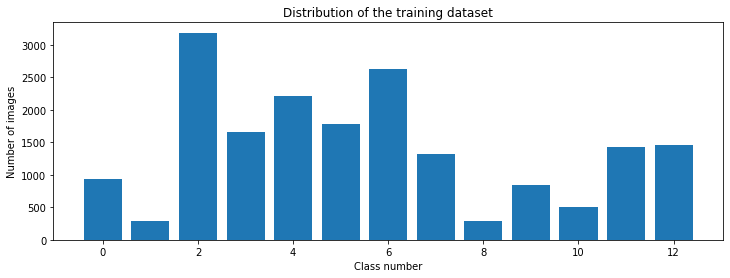

In [11]:
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)
 
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)
 
# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID - labels
 
#Check that the input sizes (x, y) matches to each other
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)

assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:]==(imageDimesions))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:]==(imageDimesions))," The dimesionas of the Validation images are wrong "
assert(X_test.shape[1:]==(imageDimesions))," The dimesionas of the Test images are wrong"
 
 
#open and read the csv file
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))
 
#Show images from different classes for example
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+row["Name"])
            num_of_samples.append(len(x_selected))
 
 
#Information about the amount of images per class
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()
 


#Preprocessing the images

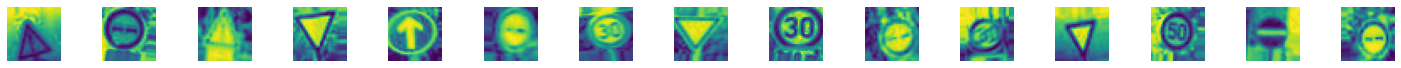

In [12]:

def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     # CONVERT TO GRAYSCALE
    img = equalize(img)      # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img/255            # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img
 
X_train=np.array(list(map(preprocessing,X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))

 
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
 
dataGen= ImageDataGenerator(width_shift_range=0.1,   # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                            height_shift_range=0.1,
                            zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                            shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                            rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch,y_batch = next(batches)
 
# TO SHOW AGMENTED IMAGE SAMPLES
fig,axs=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0],imageDimesions[1]))
    axs[i].axis('off')
plt.show()
 
 
y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)
 


# Convolution neural network model

In [13]:

def myModel():
    no_Of_Filters=60
    size_of_Filter=(5,5)
    size_of_Filter2=(3,3)
    size_of_pool=(2,2)  
    no_Of_Nodes = 500 
    model= Sequential()
    model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
 
    model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))
 
    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5)) # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses,activation='softmax'))
    # COMPILE MODEL
    model.compile(adam_v2.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model


model = myModel()
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#Train the model

In [14]:
history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)
 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
372/372 [==============================] - 174s 465ms/step - loss: 1.3365 - accuracy: 0.5466 - val_loss: 0.1979 - val_accuracy: 0.9214
Epoch 2/10
372/372 [==============================] - 173s 466ms/step - loss: 0.4106 - accuracy: 0.8637 - val_loss: 0.0502 - val_accuracy: 0.9871
Epoch 3/10
372/372 [==============================] - 173s 464ms/step - loss: 0.2347 - accuracy: 0.9222 - val_loss: 0.0270 - val_accuracy: 0.9950
Epoch 4/10
372/372 [==============================] - 173s 464ms/step - loss: 0.1745 - accuracy: 0.9431 - val_loss: 0.0207 - val_accuracy: 0.9946
Epoch 5/10
372/372 [==============================] - 173s 464ms/step - loss: 0.1391 - accuracy: 0.9545 - val_loss: 0.0272 - val_accuracy: 0.9925
Epoch 6/10
372/372 [==============================] - 173s 464ms/step - loss: 0.1117 - accuracy: 0.9646 - val_loss: 0.0134 - val_accuracy: 0.9961
Epoch 7/10
372/372 [==============================] - 173s 465ms/step - loss: 0.0931 - accuracy: 0.9710 - val_loss: 0.0112 -

#Display information about the learning process

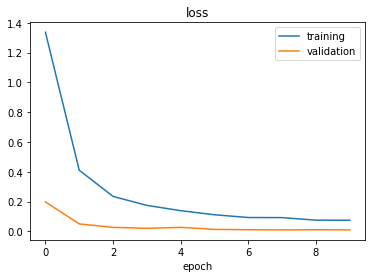

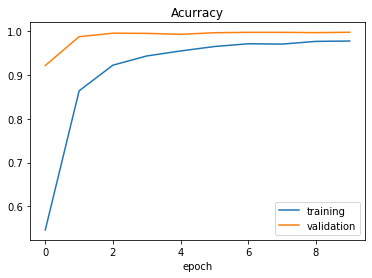

Test Score: 0.004405289422720671
Test Accuracy: 0.9987935423851013
(Comment: The presented accuracy doesn't realy indicating and the model does make mistake once in a long while


In [15]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])
 


#Save the model in .pickle file

In [16]:


pickle_out= open("model_trained_new.p","wb")
pickle.dump(model,pickle_out)
pickle_out.close()
cv2.waitKey(0)

INFO:tensorflow:Assets written to: ram://4e6a001a-28f0-4308-8d8c-bda10ccdbb8b/assets


-1